Using device: cuda (Mode: DINOv2 + Slot Attention)
Loading DINOv2 model... (this may take a moment)


Using cache found in /home/menserve/.cache/torch/hub/facebookresearch_dinov2_main
/home/menserve/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/menserve/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/menserve/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Training...
Step 0: Loss 6.509536
Step 200: Loss 2.293272
Step 400: Loss 1.834916
Step 600: Loss 1.581361
Step 800: Loss 1.395452
Visualizing...


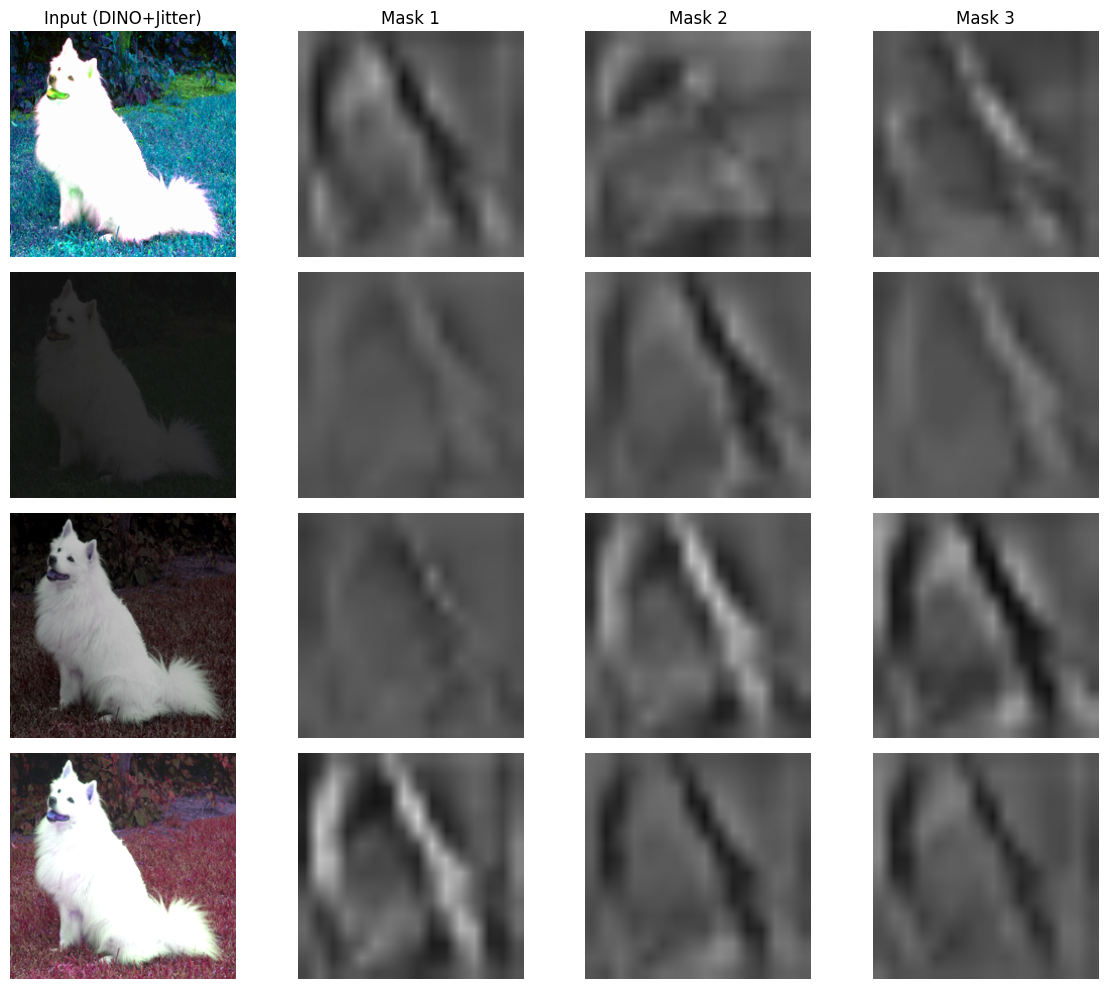

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# ==========================================
# 1. データセット (224x224, Augmentationあり)
# ==========================================
class SingleDogDataset(Dataset):
    def __init__(self, resolution=(224, 224), length=20000): 
        self.resolution = resolution
        self.length = length
        self.raw_img = self._load_dog_image()
        
        # DINOv2は平均/分散の正規化を推奨しますが、ここでは簡易的に0-1でいきます
        self.transform_train = transforms.Compose([
            transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), fill=0),
            transforms.ToTensor(),
        ])

    def _load_dog_image(self):
        url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            return img.resize(self.resolution)
        except:
            print("Download failed. Using noise.")
            return Image.fromarray(np.uint8(np.random.rand(*self.resolution, 3)*255))

    def __getitem__(self, idx):
        return self.transform_train(self.raw_img)

    def __len__(self):
        return self.length

# ==========================================
# 2. DINOv2 Feature Extractor (The Game Changer)
# ==========================================
class DinoFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # PyTorch HubからDINOv2 (ViT-Small) をロード
        print("Loading DINOv2 model... (this may take a moment)")
        self.dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        
        # パラメータ固定
        for param in self.dino.parameters():
            param.requires_grad = False
        self.dino.eval()

    def forward(self, x):
        # DINOv2は入力サイズが14の倍数であることを期待します (224 is ok)
        # 出力: (Batch, PatchNum, Dim) -> (B, 256, 384)
        # 224x224画像の場合、パッチサイズ14なので 16x16個のパッチになります
        features = self.dino.forward_features(x)["x_norm_patchtokens"]
        
        # (B, 256, 384) -> (B, 384, 16, 16) にreshape
        b, n, d = features.shape
        h = w = int(n**0.5) # 16
        features = features.permute(0, 2, 1).reshape(b, d, h, w)
        return features

# ==========================================
# 3. Slot Attention
# ==========================================
class SlotAttention(nn.Module):
    def __init__(self, num_slots, dim, iters=3, hidden_dim=128):
        super().__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.scale = dim ** -0.5
        self.norm_features = nn.LayerNorm(dim)
        self.to_q = nn.Linear(dim, dim)
        self.to_k = nn.Linear(dim, dim)
        self.to_v = nn.Linear(dim, dim)
        self.gru = nn.GRUCell(dim, dim)
        self.norm_input = nn.LayerNorm(dim)
        self.norm_slots = nn.LayerNorm(dim)
        self.norm_pre_ff = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.ReLU(inplace=True), nn.Linear(hidden_dim, dim)
        )

    def forward(self, inputs, num_slots=None):
        inputs = self.norm_features(inputs)
        b, n, d = inputs.shape
        n_s = num_slots if num_slots is not None else self.num_slots
        slots = torch.randn(b, n_s, d, device=inputs.device)
        k = self.to_k(inputs)
        v = self.to_v(inputs)
        for _ in range(self.iters):
            slots_prev = slots
            slots = self.norm_slots(slots)
            q = self.to_q(slots)
            dots = torch.einsum('bid,bjd->bij', q, k) * self.scale
            attn = dots.softmax(dim=1) + 1e-8
            attn_sum = attn.sum(dim=-1, keepdim=True)
            updates = torch.einsum('bjd,bij->bid', v, attn / attn_sum)
            slots = self.gru(updates.reshape(-1, d), slots_prev.reshape(-1, d))
            slots = slots.reshape(b, -1, d)
            slots = slots + self.mlp(self.norm_pre_ff(slots))
        return slots

# ==========================================
# 4. Model (DINO-SAUR)
# ==========================================
class DinosauerModel(nn.Module):
    def __init__(self, num_slots=3):
        super().__init__()
        self.feature_extractor = DinoFeatureExtractor()
        
        # DINOv2 ViT-Sの出力次元は 384
        self.feat_dim = 384 
        self.num_slots = num_slots 
        
        # 特徴マップサイズは 16x16 だが、DINOの特徴量は非常にリッチ
        self.pos_emb = nn.Parameter(torch.randn(1, 16, 16, self.feat_dim) * 0.05)
        
        self.slot_attention = SlotAttention(num_slots, self.feat_dim, iters=5, hidden_dim=512)
        
        # Decoder: 特徴量再構成
        # DINOの特徴量は複雑なので、Decoderも少し強くする
        self.decoder = nn.Sequential(
            nn.Conv2d(self.feat_dim + 2, 384, 5, padding=2), nn.ReLU(),
            nn.Conv2d(384, 384, 5, padding=2), nn.ReLU(),
            nn.Conv2d(384, self.feat_dim + 1, 3, padding=1)
        )

    def build_grid(self, batch_size, resolution, device):
        h, w = resolution
        x = torch.linspace(-1, 1, w, device=device)
        y = torch.linspace(-1, 1, h, device=device)
        grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
        grid = torch.stack((grid_x, grid_y), dim=0).unsqueeze(0).repeat(batch_size, 1, 1, 1)
        return grid

    def forward(self, img):
        with torch.no_grad():
            features = self.feature_extractor(img)
        
        b, c, h, w = features.shape # (B, 384, 16, 16)
        features_perm = features.permute(0, 2, 3, 1)
        features_pos = features_perm + self.pos_emb
        features_flat = features_pos.reshape(b, -1, c)
        
        slots = self.slot_attention(features_flat)
        
        slots_2d = slots.view(b * self.num_slots, self.feat_dim, 1, 1).repeat(1, 1, h, w)
        grid = self.build_grid(b * self.num_slots, (h, w), img.device)
        
        decode_in = torch.cat([slots_2d, grid], dim=1)
        out = self.decoder(decode_in)
        out = out.view(b, self.num_slots, self.feat_dim + 1, h, w)
        
        pred_feats = out[:, :, :self.feat_dim, :, :]
        masks = torch.softmax(out[:, :, self.feat_dim:, :, :], dim=1)
        
        recon_combined = torch.sum(pred_feats * masks, dim=1)
        return recon_combined, features, masks

# ==========================================
# 5. 実行
# ==========================================
def run_dino_proof():
    torch.manual_seed(42) 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device} (Mode: DINOv2 + Slot Attention)")

    dataset = SingleDogDataset(length=20000) 
    dataloader = DataLoader(dataset, batch_size=24, shuffle=True)

    model = DinosauerModel(num_slots=3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0004)

    print("Training...")
    model.train()
    
    total_steps = 2000 # DINOは強力なので短時間で収束するはず
    
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        recon_feat, target_feat, masks = model(batch)
        loss = ((target_feat - recon_feat)**2).mean()
        loss.backward()
        optimizer.step()
        
        if i % 200 == 0:
            print(f"Step {i}: Loss {loss.item():.6f}")
        if i >= total_steps:
            break

    # --- テスト (色変化) ---
    print("Visualizing...")
    model.eval()
    
    jitter_transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.5),
        transforms.ToTensor()
    ])
    
    test_batch = []
    raw_img = dataset.raw_img 
    torch.manual_seed(999) 
    for _ in range(4):
        img_jittered = jitter_transform(raw_img)
        test_batch.append(img_jittered)
    test_batch = torch.stack(test_batch).to(device)

    with torch.no_grad():
        _, _, masks = model(test_batch)

    def to_np(t): return t.permute(1, 2, 0).cpu().numpy().clip(0, 1)
    
    # 16x16 -> 224x224
    masks_resized = torch.nn.functional.interpolate(
        masks.view(-1, 1, 16, 16), 
        size=(224, 224), 
        mode='bilinear'
    ).view(4, 3, 224, 224)
    
    def mask_to_np(m): return m.cpu().numpy()

    fig, axes = plt.subplots(4, 4, figsize=(12, 10))
    axes[0, 0].set_title("Input (DINO+Jitter)")
    axes[0, 1].set_title("Mask 1")
    axes[0, 2].set_title("Mask 2")
    axes[0, 3].set_title("Mask 3")

    for row in range(4):
        axes[row, 0].imshow(to_np(test_batch[row]))
        axes[row, 0].axis('off')
        
        m_np = mask_to_np(masks_resized[row])
        for k in range(3):
            axes[row, k+1].imshow(m_np[k], cmap='gray', vmin=0, vmax=1)
            axes[row, k+1].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_dino_proof()